In [1]:
import numpy as np
#standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

In [3]:
fct = [FreezeCoreTransformer(freeze_core=True, remove_orbitals=[3,4])]

In [4]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
problem = ElectronicStructureProblem(driver, fct)
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)

# Mapping Fermions to Qubits
#num_particles = (problem.molecule_data_transformed.num_alpha,
             #problem.molecule_data_transformed.num_beta)
num_particles = problem.num_particles
qubit_op = converter.convert(main_op, num_particles = problem.num_particles)
from qiskit_nature.circuit.library import HartreeFock


num_spin_orbitals = problem.num_spin_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

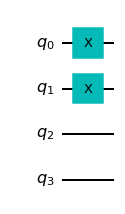

In [5]:
init_state.draw('mpl')

In [6]:
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

# Parameters for q-UCC antatze
num_particles = problem.num_particles
num_spin_orbitals = problem.num_spin_orbitals
n = qubit_op.num_qubits
qc = QuantumCircuit(qubit_op.num_qubits)
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
#the variational parameter
p=1
for i in range(n):
    theta = Parameter(f"ry_theta{p}" )
    qc.ry(theta, i)
    p += 1
qubit_label = 0
qc.ry(theta, range(n))
#qc.rz(theta, range(n))
for i in range(n-1):
    qc.cx(i, i+1)
for i in range(n):
    theta = Parameter(f"ry_theta{p}" )
    qc.ry(theta, i)
    p += 1
#qc.rz(theta, range(n))

# Add the initial state
ansatz = qc
ansatz.compose(init_state, front=True, inplace=True)

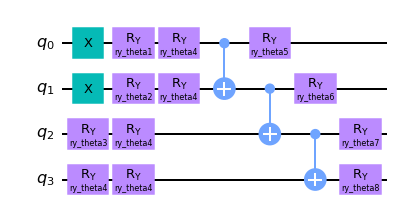

In [7]:
ansatz.draw('mpl')

In [8]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

Exact electronic energy -1.0887060157347386
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.907396311316
  - computed part:      -1.088706015735
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.881461431673
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.76300889]
    - computed part:      [0.0  0.0  4.76695575]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  -1.83884668]  Total: 1.83884668
                 (debye): [0.0  0.0  -4.67388163]  Total: 4.67388163
 


In [9]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
optimizer = COBYLA(maxiter=15000)
from qiskit.algorithms import VQE
from IPython.display import display, clear_output
def callback(eval_count, parameters, mean, std):  
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 990,
    'eigenstate': array([ 9.64056502e-04-3.72663460e-17j,  1.09754908e-04+4.85170567e-17j,
       -6.55884297e-04+3.72023903e-17j, -9.99998390e-01-1.70836155e-16j,
       -1.09941593e-06+4.35911106e-20j, -9.23091419e-05-6.80356651e-20j,
        7.95384635e-07-4.35093976e-20j,  1.07719120e-03+1.88494607e-19j,
       -2.84635924e-08+1.10118179e-21j, -7.91693145e-08-1.44292317e-21j,
        1.94039144e-08-1.09928628e-21j,  2.94727036e-05+5.03869416e-21j,
        7.94096034e-07-3.06964284e-20j,  9.33677910e-08+3.99640434e-20j,
       -5.40255251e-07+3.06437476e-20j, -8.23699436e-04-1.40718015e-19j]),
    'eigenvalue': (-1.0703580648290154+0j),
    'optimal_parameters': {   Parameter(ry_theta1): -0.1282299086434403,
                              Parameter(ry_theta2): 0.7893812768077227,
                              Parameter(ry_theta5): 0.655030190295883,
                              Parameter(ry_theta4): 0.784574495525

#### Calculating Error in Results

In [10]:
E_th = -1.0887060157347446
E_vqe = -1.0703580648290154

In [11]:
print("The percentage error in our calculation is " + str(np.abs((E_th-E_vqe)/E_th) *100)+" %")

The percentage error in our calculation is 1.6852989365863398 %
